# Benchmark Comparison Notebook
This notebook allows you to upload multiple `result.json` files to compare their benchmark results visually.

After running the first block, you can upload the zip files from GitHub directly.

In [1]:
import zipfile
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import FileUpload

# Create a file upload widget
uploader = FileUpload(multiple=True)
uploader

FileUpload(value=(), description='Upload', multiple=True)

In [2]:
# Unpack and process the uploaded ZIP files grouped by machine and version
dfs = []
for uploaded_file in uploader.value:
    content = bytes(uploaded_file['content'])  # Convert memoryview to bytes
    filename = uploaded_file['name']
    
    # Extract machine and pixi version from the filename
    parts = filename.replace(".zip", "").split('-v')
    machine_type = parts[0]
    pixi_version = parts[1].split("-bench")[0]
    
    # Create a temporary directory for extraction
    extracted_folder = f"./extracted_{filename}"
    os.makedirs(extracted_folder, exist_ok=True)
    
    # Save and extract the ZIP file
    temp_zip_path = os.path.join(extracted_folder, filename)
    with open(temp_zip_path, 'wb') as f:
        f.write(content)
    
    with zipfile.ZipFile(temp_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)

    # Process the extracted JSON files
    for root, dirs, files in os.walk(extracted_folder):
        for file in files:
            if file.endswith(".json"):
                with open(os.path.join(root, file), 'r') as json_file:
                    data = json.load(json_file)
                    for entry in data['results']:
                        e_flag = entry['command'].split('-e')[-1].strip()
                        dfs.append({
                            'machine_type': machine_type,
                            'pixi_version': pixi_version,
                            'e_flag': e_flag,
                            'mean_time': entry['mean']
                        })

# Convert to DataFrame
df = pd.DataFrame(dfs)
df.head()

,machine_type,pixi_version,e_flag,mean_time
0,macos-13,0.39.2,simple,0.934361
1,macos-13,0.39.2,python,3.520563
2,macos-13,0.39.2,extreme,61.165546
3,macos-13,0.39.5,simple,0.829307
4,macos-13,0.39.5,python,1.766352


In [3]:
# Ensure the dataframe is properly prepared from the beginning
# Pivot and melt the data for the bar chart
df_pivot = df.pivot_table(
    values="mean_time", 
    index=["machine_type", "e_flag"], 
    columns="pixi_version"
).reset_index()

# Flatten the data for easier plotting
df_pivot_melted = df_pivot.melt(
    id_vars=["machine_type", "e_flag"],
    var_name="pixi_version",
    value_name="mean_time"
)

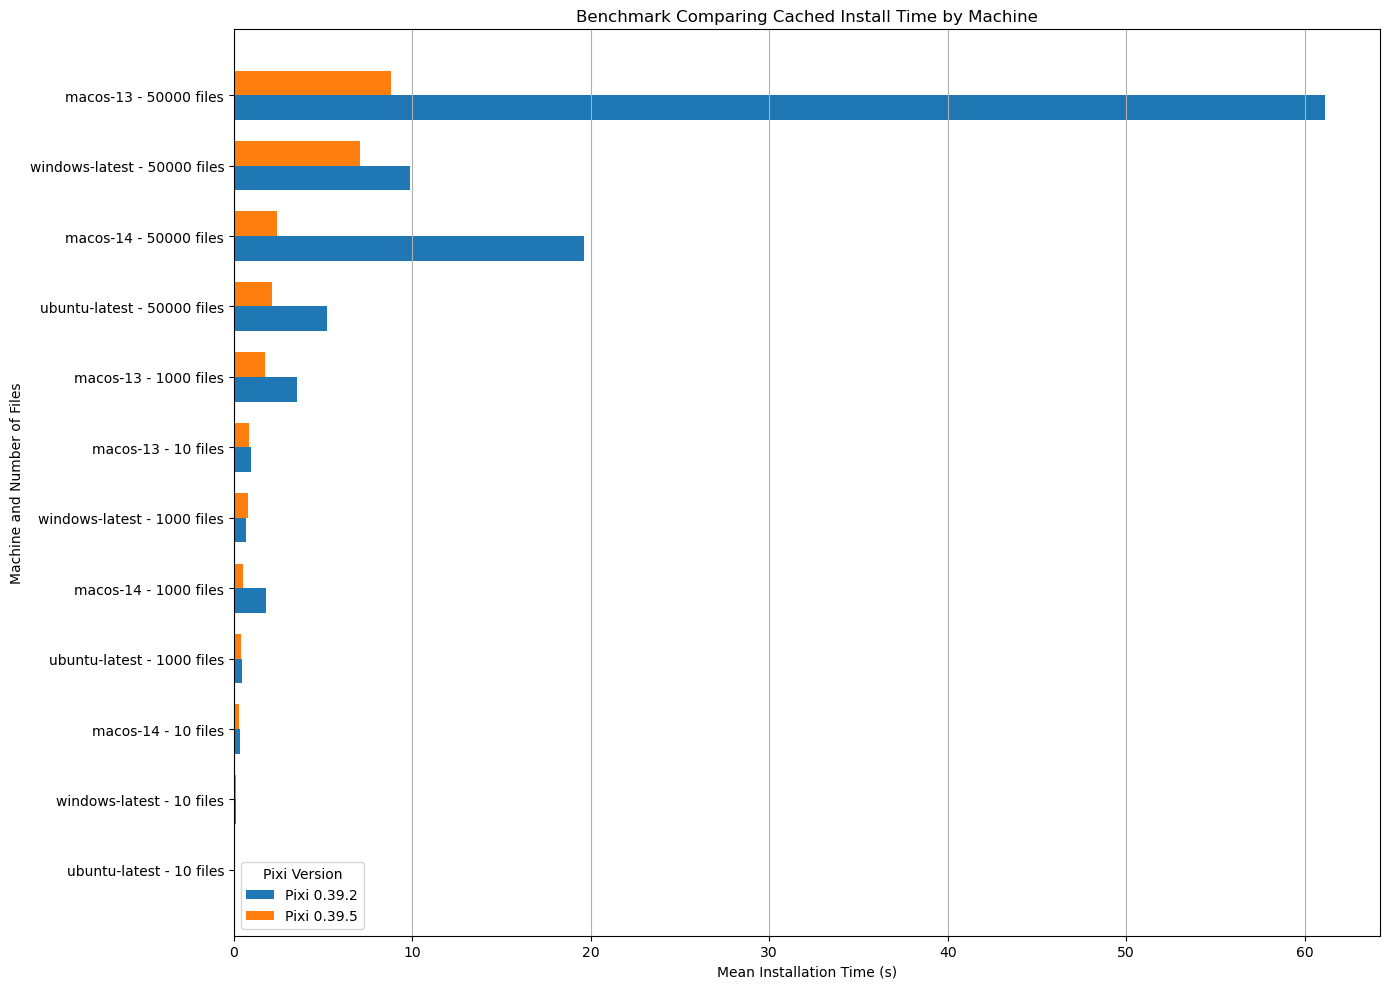

In [4]:

# Ensure the dataframe is properly prepared from the beginning
# Pivot and melt the data for the bar chart
df_pivot = df.pivot_table(
    values="mean_time", 
    index=["machine_type", "e_flag"], 
    columns="pixi_version"
).reset_index()

# Flatten the data for easier plotting
df_pivot_melted = df_pivot.melt(
    id_vars=["machine_type", "e_flag"],
    var_name="pixi_version",
    value_name="mean_time"
)

# Replace -e flags with the correct number of files BEFORE any transformations
e_flag_map = {
    "simple": "10 files",
    "python": "1000 files",
    "extreme": "50000 files"
}
df_pivot_melted['e_flag'] = df_pivot_melted['e_flag'].map(e_flag_map)
df_pivot_melted['label'] = df_pivot_melted['machine_type'] + " - " + df_pivot_melted['e_flag']

# Calculate the improvement by taking the difference between old and new versions
improvement_df = df_pivot_melted.groupby("label")['mean_time'].min().reset_index()
improvement_df = improvement_df.sort_values(by="mean_time", ascending=True)

# Reorder the data by the biggest improvement (smallest mean_time)
sorted_labels = improvement_df['label'].tolist()
df_pivot_melted['label'] = pd.Categorical(df_pivot_melted['label'], categories=sorted_labels, ordered=True)

# Split bars slightly apart by creating offsets
unique_labels = df_pivot_melted['label'].unique()
bar_width = 0.35  # Adjusted bar width for better spacing
x_pos = np.arange(len(unique_labels))  # Generate positions based on the data length

# Prepare a figure
plt.figure(figsize=(14, 10))

# Plot each version separately with properly adjusted positions
for idx, version in enumerate(df_pivot_melted['pixi_version'].unique()):
    subset = df_pivot_melted[df_pivot_melted['pixi_version'] == version].sort_values(by="label")
    if not subset.empty:
        # Adjust x positions for each version
        plt.barh(
            x_pos + (idx * bar_width) - (bar_width / 2),  
            subset['mean_time'].values, 
            height=bar_width, 
            label=f"Pixi {version}",
            align='center'
        )

# Set the labels and formatting
plt.yticks(x_pos, sorted_labels)
plt.title('Benchmark Comparing Cached Install Time by Machine')
plt.xlabel('Mean Installation Time (s)')
plt.ylabel('Machine and Number of Files')

# Use Pixi version as the legend label
plt.legend(title="Pixi Version")
plt.grid(axis='x')
plt.tight_layout()
plt.show()